In [1]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import constants
import model_utils

In [2]:
df = pd.read_json('equalized_emotions_dataset_pl.json')
df

,text,emotions,text_pl
0,i feel totally greedy,anger,Czuję się całkowicie chciwy
1,i feel so overwhelmed with emotions,fear,Czuję się tak przytłoczony emocjami
2,i didnt feel the g force effect i am stunned i...,surprise,Nie czułem efektu siły g Jestem oszołomiony Po...
3,ive just got to tell you all that im feeling r...,anger,ive just got to tell you all that I feel Racze...
4,i told you i was sorry you were feeling frustr...,anger,"Powiedziałem ci, że przepraszam, że czujesz si..."
...,...,...,...
39995,im feeling quite generous lately as ive been w...,joy,"czuję się ostatnio dość hojny, ponieważ pracuj..."
39996,i feel like some of the characters dont deserv...,love,"Czuję, że niektóre postacie nie zasługują na w..."
39997,im feel fear within my bones that cant be shak...,fear,"Czuję strach w moich kościach, którego nie moż..."
39998,ive been feeling more creative and less like a...,joy,Czułem się bardziej kreatywny i mniej jak czys...


In [3]:
df = df.drop(columns=['text'])
df

,emotions,text_pl
0,anger,Czuję się całkowicie chciwy
1,fear,Czuję się tak przytłoczony emocjami
2,surprise,Nie czułem efektu siły g Jestem oszołomiony Po...
3,anger,ive just got to tell you all that I feel Racze...
4,anger,"Powiedziałem ci, że przepraszam, że czujesz si..."
...,...,...
39995,joy,"czuję się ostatnio dość hojny, ponieważ pracuj..."
39996,love,"Czuję, że niektóre postacie nie zasługują na w..."
39997,fear,"Czuję strach w moich kościach, którego nie moż..."
39998,joy,Czułem się bardziej kreatywny i mniej jak czys...


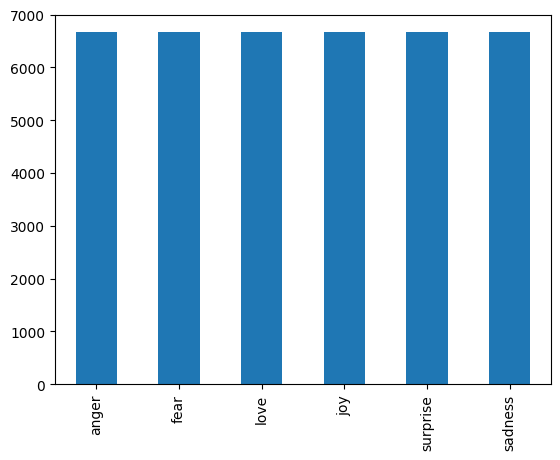

In [4]:
data = df["emotions"]
data.value_counts().plot.bar()
plt.show()

In [5]:
ordered_class_labels = {
    "joy": 0,
    "love": 1,
    "surprise": 2,
    "sadness": 3,
    "anger": 4,
    "fear": 5,
}

In [6]:
df = df.replace({"emotions": ordered_class_labels})

In [7]:
!pip install datasets
from datasets import Dataset

raw_dataset = Dataset.from_pandas(df).remove_columns("__index_level_0__")
raw_dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 20.2 MB/s eta 0:00:00


Dataset({
    features: ['emotions', 'text_pl'],
    num_rows: 40000
})

In [8]:
!pip install transformers
from transformers import AutoTokenizer

checkpoint = "dkleczek/bert-base-polish-uncased-v1"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 89.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.7 MB/s eta 0:00:00


In [9]:
def tokenize_function(example):
    return tokenizer(example["text_pl"], truncation=True)


tokenized_dataset = raw_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [10]:
# Train set: 80%, Validation set: 10%, Test set: 10%
tokenized_train_dataset, tokenized_val_dataset, tokenized_test_dataset = model_utils.split_train_val_test(
    tokenized_dataset,
    train_size=0.8,
    test_size_of_val_test_batch=0.5)

In [11]:
from transformers import DataCollatorWithPadding

columns = ["attention_mask", "input_ids", "token_type_ids"]
label_cols = ["emotions"]
batch_size = 16
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_dataset = model_utils.convert_to_tf_dataset(tokenized_train_dataset, columns, label_cols, data_collator,
                                                     batch_size)
tf_val_dataset = model_utils.convert_to_tf_dataset(tokenized_val_dataset, columns, label_cols, data_collator,
                                                   batch_size)
tf_test_dataset = model_utils.convert_to_tf_dataset(tokenized_test_dataset, columns, label_cols, data_collator,
                                                    batch_size)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [12]:
# Model parameters
training_number = 3
model_name = "emotions_pl_bert"

training_name = f"training_{training_number}"
checkpoint_filename_template = "cp-{epoch:04d}.ckpt"
checkpoints_dir = os.path.join(constants.TRAINING_CHECKPOINTS_PATH, model_name, training_name)
figures_dir = "figures"
checkpoint_path = os.path.join(checkpoints_dir, checkpoint_filename_template)

In [13]:
# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True)
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=3)
callbacks = [checkpoint_cb, early_stop_cb]

In [14]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam

num_epochs = 10
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)

optimizer = Adam(learning_rate=lr_scheduler)

In [15]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=6, from_pt=True)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# Compile
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ["accuracy"]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [17]:
history = model.fit(tf_train_dataset, validation_data=tf_val_dataset, epochs=num_epochs, callbacks=callbacks)

Epoch 1/10
2000/2000 [==============================] - ETA: 0s - loss: 0.5444 - accuracy: 0.8174
Epoch 1: saving model to ../../training_checkpoints/emotions_pl_bert/training_3/cp-0001.ckpt
2000/2000 [==============================] - 518s 233ms/step - loss: 0.5444 - accuracy: 0.8174 - val_loss: 0.4254 - val_accuracy: 0.8583
Epoch 2/10
2000/2000 [==============================] - ETA: 0s - loss: 0.3074 - accuracy: 0.8930
Epoch 2: saving model to ../../training_checkpoints/emotions_pl_bert/training_3/cp-0002.ckpt
2000/2000 [==============================] - 432s 216ms/step - loss: 0.3074 - accuracy: 0.8930 - val_loss: 0.4139 - val_accuracy: 0.8680
Epoch 3/10
2000/2000 [==============================] - ETA: 0s - loss: 0.2209 - accuracy: 0.9210
Epoch 3: saving model to ../../training_checkpoints/emotions_pl_bert/training_3/cp-0003.ckpt
2000/2000 [==============================] - 431s 216ms/step - loss: 0.2209 - accuracy: 0.9210 - val_loss: 0.4529 - val_accuracy: 0.8670
Epoch 4/10
2000/

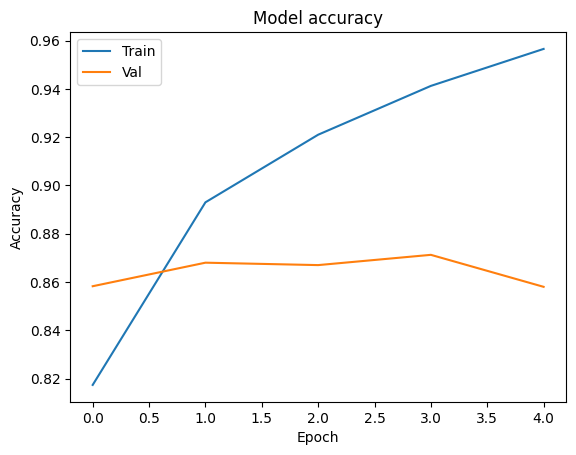

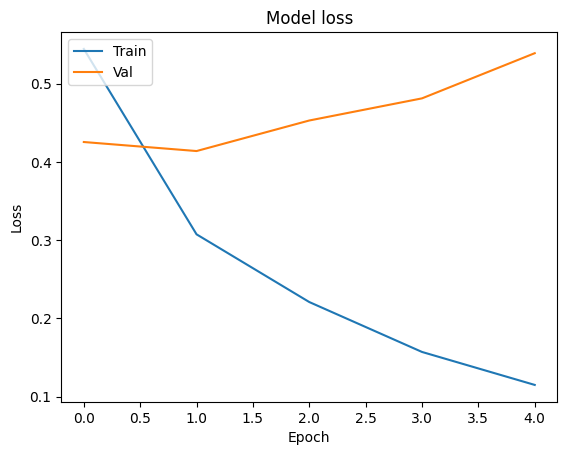

In [18]:
model_utils.plot_and_save_fig_from_history(history,
                                           attributes=['accuracy', 'val_accuracy'],
                                           title='Model accuracy',
                                           y_label='Accuracy',
                                           x_label='Epoch',
                                           legend_descriptors=['Train', 'Val'],
                                           figure_dir_path=figures_dir,
                                           figure_filename=f"{training_name}_accuracy.png")

model_utils.plot_and_save_fig_from_history(history,
                                           attributes=['loss', 'val_loss'],
                                           title='Model loss',
                                           y_label='Loss',
                                           x_label='Epoch',
                                           legend_descriptors=['Train', 'Val'],
                                           figure_dir_path=figures_dir,
                                           figure_filename=f"{training_name}_loss.png")

In [19]:
best_model = model_utils.get_best_model_from_checkpoints(model, history,
                                                         checkpoints_dir=checkpoints_dir,
                                                         checkpoint_filename_template=checkpoint_filename_template)

In [20]:
model_utils.save_model(best_model, model_name=model_name, training_number=training_number, saved_models_dir=constants.SAVED_MODEL_LOCATION, default_model_version=constants.DEFAULT_MODEL_VERSION)

In [21]:
# Evaluation
best_model.evaluate(tf_test_dataset, batch_size=batch_size)

250/250 [==============================] - 19s 74ms/step - loss: 0.4244 - accuracy: 0.8670


[0.4244207739830017, 0.8669999837875366]

In [22]:
class_preds = model_utils.get_class_preds(model, tf_test_dataset)

250/250 [==============================] - 22s 75ms/step


In [25]:
precision, recall, f1 = model_utils.get_classification_evaluation_metrics(
    class_actual=tokenized_test_dataset['emotions'],
    class_preds=class_preds,
    average='micro')

print(f"Precision score: ", precision)
print(f"Recall score: ", recall)
print(f"F1 score: ", f1)

Precision score:  0.867
Recall score:  0.867
F1 score:  0.867


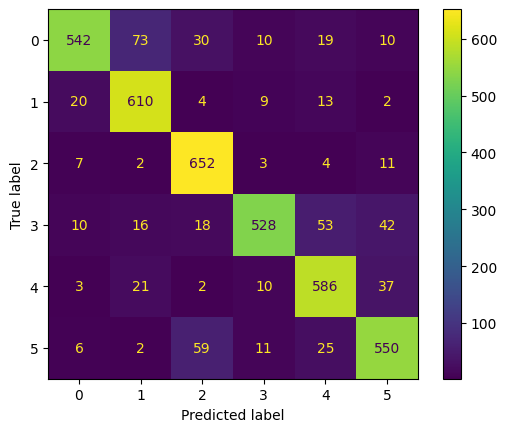

In [26]:
model_utils.plot_and_save_conf_matrix(class_actual=tokenized_test_dataset['emotions'],
                                      class_preds=class_preds,
                                      figure_dir_path=figures_dir,
                                      figure_filename=f"{training_name}_confmatrix.png")

In [28]:
model_utils.print_incorrectly_predicted_texts(texts=raw_dataset['text_pl'],
                                              class_actual=raw_dataset['emotions'],
                                              class_preds=class_preds)


            BAD PREDICTION:
            - INDEX: 1
            - TEXT: Czuję się tak przytłoczony emocjami
            - PREDICTED VALUE: 1
            - CORRECT VALUE: 5
            

            BAD PREDICTION:
            - INDEX: 3
            - TEXT: ive just got to tell you all that I feel Raczej niecierpliwy
            - PREDICTED VALUE: 2
            - CORRECT VALUE: 4
            

            BAD PREDICTION:
            - INDEX: 5
            - TEXT: Czuję się nieco niepewnie prosząc o pomoc w pomaganiu mi w finansowaniu tej podróży, ponieważ wydaje się to bardzo pobłażliwą rzeczą, którą można poprosić o pomoc.
            - PREDICTED VALUE: 2
            - CORRECT VALUE: 5
            

            BAD PREDICTION:
            - INDEX: 6
            - TEXT: Czuję się mniej szalony o mojej kolekcji teraz niż wtedy, gdy byłem stale ulepszając go
            - PREDICTED VALUE: 0
            - CORRECT VALUE: 5
            

            BAD PREDICTION:
            - INDEX: 8
   

In [ ]:
!zip -r documentation.zip figures

In [ ]:
from google.colab import files
files.download("documentation.zip")